# Inteligencia Artificial en la Detección del Cáncer

### Paso 1: Importar y preparar el conjunto de datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Cargar el conjunto de datos desde el repositorio UCI
url_datos = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
nombre_columnas = [
    "ID",
    "grosor",
    "tamaño_celula",
    "forma_celula",
    "adhesion",
    "tamaño_epitelial",
    "nucleos_desnudos",
    "cromatina_blanda",
    "nucleolos_normales",
    "mitosis",
    "clase"
]

cancer = pd.read_csv(url_datos, header=None, names=nombre_columnas)

# Preprocesamiento de datos
cancer["nucleos_desnudos"] = cancer["nucleos_desnudos"].replace("?", np.nan)
cancer = cancer.dropna()
cancer["clase"] = (cancer["clase"] / 2) - 1

# Dividir el conjunto de datos en entrenamiento y prueba
X = cancer.iloc[:, 1:-1].values
y = cancer["clase"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=80817
)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Paso 2: Entrenar los algoritmos de aprendizaje automático

In [4]:
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

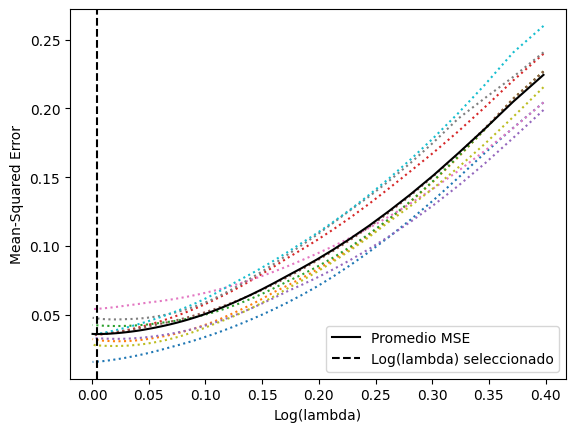

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Entrenar el modelo LASSO
lasso = LassoCV(cv=10, random_state=80817)
lasso.fit(X_train, y_train)

# Crear las gráficas de los resultados de LASSO
plt.figure()
plt.plot(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1), "k", label="Promedio MSE")
plt.axvline(lasso.alpha_, linestyle="--", color="k", label="Log(lambda) seleccionado")
plt.xlabel("Log(lambda)")
plt.ylabel("Mean-Squared Error")
plt.legend()
plt.show()

# Entrenar el modelo SVM
svm = SVC(kernel="rbf", gamma=1 / (X_train.shape[1] - 1), C=1, probability=True)
svm.fit(X_train, y_train)

# Entrenar el modelo de red neuronal
model = Sequential()
model.add(Dense(5, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)

### Paso 3: Probar los algoritmos de aprendizaje automático

In [6]:
# Hacer predicciones
prediccion_lasso = lasso.predict(X_test)
prediccion_svm = svm.predict(X_test)
prediccion_nnet = model.predict(X_test).flatten()

# Opcional: Crear un modelo ensemble
predicciones = pd.DataFrame(
    {"lasso": prediccion_lasso, "svm": prediccion_svm, "nnet": prediccion_nnet}
)
predicciones["votos_ensemble"] = predicciones.mean(axis=1).round()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### Paso 4: Evaluar la sensibilidad, especificidad y precisión de los algoritmos

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

Matriz de confusión para LASSO:
[[139   4]
 [  7  76]]
Matriz de confusión para SVM:
[[138   5]
 [  3  80]]
Matriz de confusión para Red Neuronal:
[[139   4]
 [  3  80]]
Matriz de confusión para Ensemble:
[[139   4]
 [  3  80]]


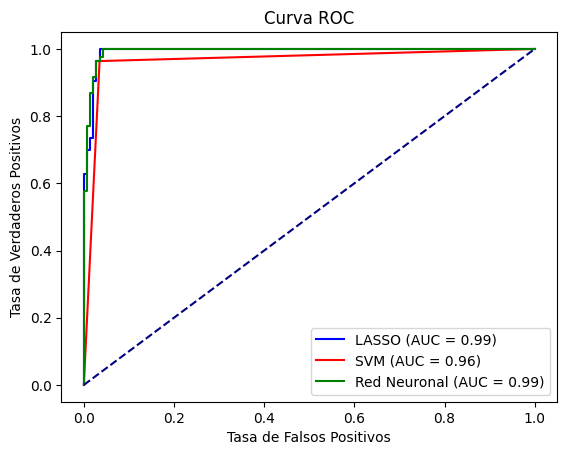

In [8]:
# Evaluación de la matriz de confusión
print("Matriz de confusión para LASSO:")
print(confusion_matrix(y_test, prediccion_lasso.round()))
print("Matriz de confusión para SVM:")
print(confusion_matrix(y_test, prediccion_svm.round()))
print("Matriz de confusión para Red Neuronal:")
print(confusion_matrix(y_test, prediccion_nnet.round()))
print("Matriz de confusión para Ensemble:")
print(confusion_matrix(y_test, predicciones["votos_ensemble"]))

# Análisis de la curva ROC
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, prediccion_lasso)
fpr_svm, tpr_svm, _ = roc_curve(y_test, prediccion_svm)
fpr_nnet, tpr_nnet, _ = roc_curve(y_test, prediccion_nnet)

roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
roc_auc_svm = auc(fpr_svm, tpr_svm)
roc_auc_nnet = auc(fpr_nnet, tpr_nnet)

# Graficar las curvas ROC
plt.figure()
plt.plot(fpr_lasso, tpr_lasso, color="blue", label=f"LASSO (AUC = {roc_auc_lasso:.2f})")
plt.plot(fpr_svm, tpr_svm, color="red", label=f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot(
    fpr_nnet, tpr_nnet, color="green", label=f"Red Neuronal (AUC = {roc_auc_nnet:.2f})"
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

### Paso 5: Aplicar nuevos datos a los modelos entrenados

In [9]:
# Hacer nuevas predicciones con los modelos entrenados
nuevos_datos = np.array([[8, 7, 8, 5, 5, 7, 9, 8, 10]])
nuevos_datos = scaler.transform(nuevos_datos)

nueva_prediccion_lasso = lasso.predict(nuevos_datos)
nueva_prediccion_svm = svm.predict(nuevos_datos)
nueva_prediccion_nnet = model.predict(nuevos_datos).flatten()

print("Predicción LASSO:", nueva_prediccion_lasso)
print("Predicción SVM:", nueva_prediccion_svm)
print("Predicción Red Neuronal:", nueva_prediccion_nnet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicción LASSO: [0.99160405]
Predicción SVM: [1.]
Predicción Red Neuronal: [0.99995774]
